In [1]:
import numpy as np
import pandas as pd
import math
import sys 
sys.path.append('/home/riccardo/GraRed')
from GraRed import Catalogue
import matplotlib.pyplot as plt
from GraRed import utils as ut
import itertools
from GraRed import Fit_bckg_corr as fbc
from GraRed import plot_utils as pu
import emcee
from scipy.optimize import minimize
from GraRed import mcmc as mc
import corner

/home/riccardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df =pd.read_parquet('/home/riccardo/GraRed/Data/SDSS_galaxy_cat.parquet')
gal = Catalogue.Galaxies(df['RA[deg]'].values,df['DEC[deg]'].values,df['Z'].values,redshift_err=df['zerr'].values)

df =pd.read_parquet('/home/riccardo/GraRed/Data/WH15_cluster_cat.parquet')
m = 1.08*np.log10(df.RL500.values) - 1.37 +14
df['M500']=10**m

rand_gen = np.random.default_rng(12345)


dd = df.loc[rand_gen.choice(df.index,10000,replace=False)]

cl = Catalogue.Cluster(dd['RA[deg]'].values,dd['Dec[deg]'].values,dd['z'].values,mass=dd['M500'].values,radius=dd['R500[Mpc]'].values,
concentration=None,is_crit=True, delta=500,gravity='GR', seed=1234)

dd=pd.read_parquet('/home/riccardo/catalogo.parquet')

if the masses are in logharitmic scale, please change it or the code will not work


In [3]:
df=dd[dd.num_mean_centr > 1]
r=df.dist_member
rarray=list(itertools.chain.from_iterable(r))
varray=list(itertools.chain.from_iterable(df.vel_member/1000))
histo,xedges,yedges=fbc.create_histo(rarray,varray,0.05,0.05)

In [4]:
fit_func,par=fbc.fit_histo(histo,xedges,yedges,3,"Lin_2")
new_hist=fbc.hist_bckg_rem(histo,fit_func)
histog=fbc.histo_cut_norm(4,histo,fit_func,xedges,yedges)
err=fbc.err_norm(4,histo,fit_func,xedges,yedges,3)

In [5]:
init=[0.5,1.0,1.5,0.]
par=[0,1,0.,10,0.1]
walker_par=[1234,1e-4,50,25000,100,15]

sampler,flat_samples=mc.mcmc(init,yedges,histog[1,:],err[1,:],"2Gauss",par,walker_par,"./chain")

100%|████████████████████████████████████| 25000/25000 [01:04<00:00, 386.74it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

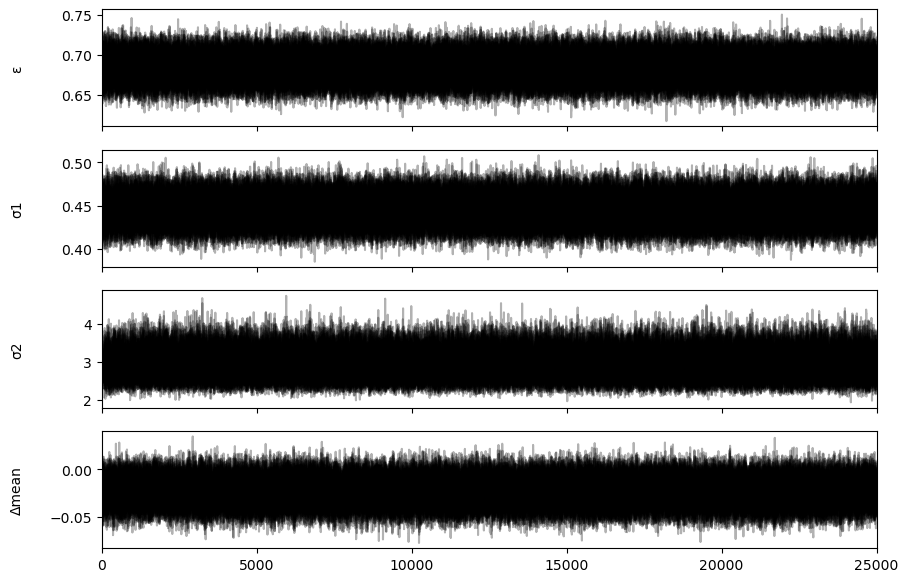

In [6]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ["\u03B5", "\u03C3"+"1","\u03C3"+"2", "\u0394"+"mean","log(f)"]
for i in range(len(par)):
    ax = axes[i]
    ax.plot(sampler[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(sampler))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

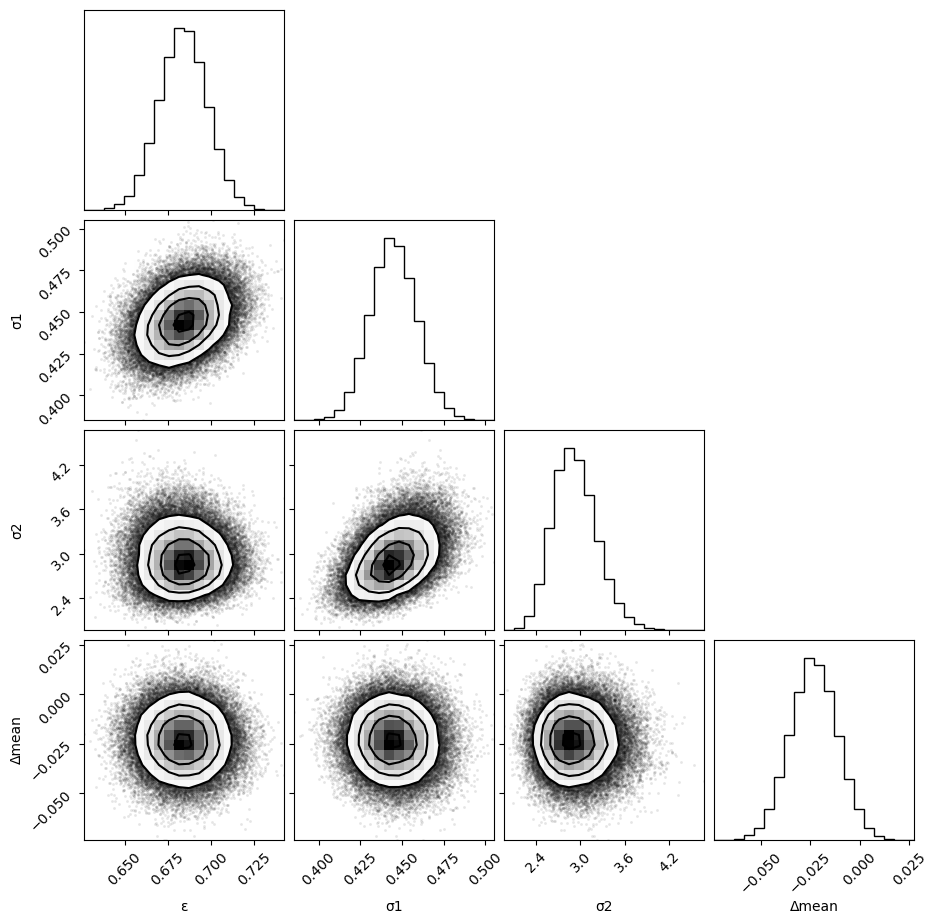

In [7]:
fig = corner.corner(flat_samples, labels=labels, )